# Project 4: Reducing Noise in Our Input Data

## Understanding Neural Noise

### Importing previous step

In [1]:
from Project2 import *

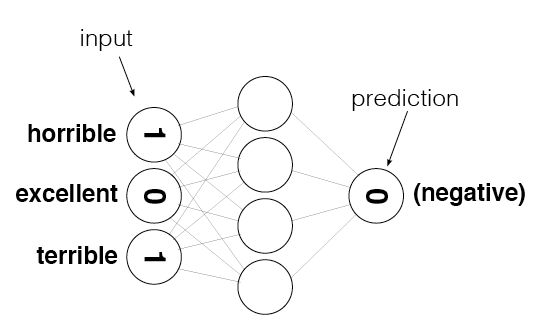

In [2]:
from IPython.display import Image
Image(filename='sentiment_network.png')

In [3]:
def update_input_layer(review):
    
    global layer_0
    
    # clear out previous state, reset the layer to be all 0s
    layer_0 *= 0
    for word in review.split(" "):
        layer_0[0][word2index[word]] += 1

update_input_layer(reviews[0])

In [4]:
layer_0

array([[18.,  0.,  0., ...,  0.,  0.,  0.]])

In [5]:
review_counter = Counter()
for word in reviews[0].split(" "):
    review_counter[word] += 1

In [6]:
review_counter.most_common()[:30]

[('.', 27),
 ('', 18),
 ('the', 9),
 ('to', 6),
 ('high', 5),
 ('i', 5),
 ('bromwell', 4),
 ('is', 4),
 ('a', 4),
 ('teachers', 4),
 ('that', 4),
 ('of', 4),
 ('it', 2),
 ('at', 2),
 ('as', 2),
 ('school', 2),
 ('my', 2),
 ('in', 2),
 ('me', 2),
 ('students', 2),
 ('their', 2),
 ('student', 2),
 ('cartoon', 1),
 ('comedy', 1),
 ('ran', 1),
 ('same', 1),
 ('time', 1),
 ('some', 1),
 ('other', 1),
 ('programs', 1)]

TODO: Attempt to reduce the noise in the input data.

* Copy the SentimentNetwork class we created earlier into the following cell.
* Modify update_input_layer so it does not count how many times each word is used, but rather just stores whether or not a word   was used.

The following code is the same as the previous project, with project-specific changes marked with "New for Project 4"

In [7]:
import time
import sys
import numpy as np

# Encapsulate our neural network in a class
class SentimentNetwork:
    def __init__(self, reviews,labels,hidden_nodes = 10, learning_rate = 0.1):
        """Create a SentimenNetwork with the given settings
        Args:
            reviews(list) - List of reviews used for training
            labels(list) - List of POSITIVE/NEGATIVE labels associated with the given reviews
            hidden_nodes(int) - Number of nodes to create in the hidden layer
            learning_rate(float) - Learning rate to use while training
        
        """
        # Assign a seed to our random number generator to ensure we get
        # reproducable results during development 
        np.random.seed(1)

        # process the reviews and their associated labels so that everything
        # is ready for training
        self.pre_process_data(reviews, labels)
        
        # Build the network to have the number of hidden nodes and the learning rate that
        # were passed into this initializer. Make the same number of input nodes as
        # there are vocabulary words and create a single output node.
        self.init_network(len(self.review_vocab),hidden_nodes, 1, learning_rate)

    def pre_process_data(self, reviews, labels):
        
        # populate review_vocab with all of the words in the given reviews
        review_vocab = set()
        for review in reviews:
            for word in review.split(" "):
                review_vocab.add(word)

        # Convert the vocabulary set to a list so we can access words via indices
        self.review_vocab = list(review_vocab)
        
        # populate label_vocab with all of the words in the given labels.
        label_vocab = set()
        for label in labels:
            label_vocab.add(label)
        
        # Convert the label vocabulary set to a list so we can access labels via indices
        self.label_vocab = list(label_vocab)
        
        # Store the sizes of the review and label vocabularies.
        self.review_vocab_size = len(self.review_vocab)
        self.label_vocab_size = len(self.label_vocab)
        
        # Create a dictionary of words in the vocabulary mapped to index positions
        self.word2index = {}
        for i, word in enumerate(self.review_vocab):
            self.word2index[word] = i
        
        # Create a dictionary of labels mapped to index positions
        self.label2index = {}
        for i, label in enumerate(self.label_vocab):
            self.label2index[label] = i
        
    def init_network(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Store the learning rate
        self.learning_rate = learning_rate

        # Initialize weights

        # These are the weights between the input layer and the hidden layer.
        self.weights_0_1 = np.zeros((self.input_nodes,self.hidden_nodes))
    
        # These are the weights between the hidden layer and the output layer.
        self.weights_1_2 = np.random.normal(0.0, self.output_nodes**-0.5, 
                                                (self.hidden_nodes, self.output_nodes))
        
        # The input layer, a two-dimensional matrix with shape 1 x input_nodes
        self.layer_0 = np.zeros((1,input_nodes))
    
        
    def update_input_layer(self,review):

        # clear out previous state, reset the layer to be all 0s
        self.layer_0 *= 0
        
        for word in review.split(" "):
            # NOTE: This if-check was not in the version of this method created in Project 2.
            #       It simply ensures the word is actually a key in word2index before
            #       accessing it, which is important because accessing an invalid key
            #       with raise an exception in Python. This allows us to ignore unknown
            #       words encountered in new reviews.
            if(word in self.word2index.keys()):
                ## New for Project 4: changed to set to 1 instead of add 1
                self.layer_0[0][self.word2index[word]] = 1
                
    def get_target_for_label(self,label):
        if(label == 'POSITIVE'):
            return 1
        else:
            return 0
        
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_output_2_derivative(self,output):
        return output * (1 - output)
    
    def train(self, training_reviews, training_labels):
        
        # make sure out we have a matching number of reviews and labels
        assert(len(training_reviews) == len(training_labels))
        
        # Keep track of correct predictions to display accuracy during training 
        correct_so_far = 0

        # Remember when we started for printing time statistics
        start = time.time()
        
        # loop through all the given reviews and run a forward and backward pass,
        # updating weights for every item
        for i in range(len(training_reviews)):
            
            # Get the next review and its correct label
            review = training_reviews[i]
            label = training_labels[i]
            
            #### Implement the forward pass here ####
            ### Forward pass ###

            # Input Layer
            self.update_input_layer(review)

            # Hidden layer
            layer_1 = self.layer_0.dot(self.weights_0_1)

            # Output layer
            layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # Output error
            layer_2_error = layer_2 - self.get_target_for_label(label) # Output layer error is the difference between desired target and actual output.
            layer_2_delta = layer_2_error * self.sigmoid_output_2_derivative(layer_2)

            # Backpropagated error
            layer_1_error = layer_2_delta.dot(self.weights_1_2.T) # errors propagated to the hidden layer
            layer_1_delta = layer_1_error # hidden layer gradients - no nonlinearity so it's the same as the error

            # Update the weights
            self.weights_1_2 -= layer_1.T.dot(layer_2_delta) * self.learning_rate # update hidden-to-output weights with gradient descent step
            self.weights_0_1 -= self.layer_0.T.dot(layer_1_delta) * self.learning_rate # update input-to-hidden weights with gradient descent step

            # Keep track of correct predictions.
            if(layer_2 >= 0.5 and label == 'POSITIVE'):
                correct_so_far += 1
            elif(layer_2 < 0.5 and label == 'NEGATIVE'):
                correct_so_far += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the training process. 
            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                             + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
            if(i % 2500 == 0):
                print("")
    
    def test(self, testing_reviews, testing_labels):
        """
        Attempts to predict the labels for the given testing_reviews,
        and uses the test_labels to calculate the accuracy of those predictions.
        """
        
        # keep track of how many correct predictions we make
        correct = 0

        # we'll time how many predictions per second we make
        start = time.time()

        # Loop through each of the given reviews and call run to predict
        # its label. 
        for i in range(len(testing_reviews)):
            pred = self.run(testing_reviews[i])
            if(pred == testing_labels[i]):
                correct += 1
            
            # For debug purposes, print out our prediction accuracy and speed 
            # throughout the prediction process. 

            elapsed_time = float(time.time() - start)
            reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
            
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                             + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                             + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                             + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
    
    def run(self, review):
        """
        Returns a POSITIVE or NEGATIVE prediction for the given review.
        """
        # Run a forward pass through the network, like in the "train" function.
        
        # Input Layer
        self.update_input_layer(review.lower())

        # Hidden layer
        layer_1 = self.layer_0.dot(self.weights_0_1)

        # Output layer
        layer_2 = self.sigmoid(layer_1.dot(self.weights_1_2))
        
        # Return POSITIVE for values above greater-than-or-equal-to 0.5 in the output layer;
        # return NEGATIVE for other values
        if(layer_2[0] >= 0.5):
            return "POSITIVE"
        else:
            return "NEGATIVE"

Run the following cell to recreate the network and train it. Notice we've gone back to the higher learning rate of 0.1.

In [8]:
mlp = SentimentNetwork(reviews[:-1000],labels[:-1000], learning_rate=0.1)
mlp.train(reviews[:-1000],labels[:-1000])

Progress:0.0% Speed(reviews/sec):0.0 #Correct:1 #Trained:1 Training Accuracy:100.%
Progress:10.4% Speed(reviews/sec):76.32 #Correct:1725 #Trained:2501 Training Accuracy:68.9%
Progress:20.8% Speed(reviews/sec):74.78 #Correct:3696 #Trained:5001 Training Accuracy:73.9%
Progress:31.2% Speed(reviews/sec):74.67 #Correct:5771 #Trained:7501 Training Accuracy:76.9%
Progress:41.6% Speed(reviews/sec):74.48 #Correct:7907 #Trained:10001 Training Accuracy:79.0%
Progress:52.0% Speed(reviews/sec):74.58 #Correct:10025 #Trained:12501 Training Accuracy:80.1%
Progress:62.5% Speed(reviews/sec):74.76 #Correct:12148 #Trained:15001 Training Accuracy:80.9%
Progress:72.9% Speed(reviews/sec):74.72 #Correct:14259 #Trained:17501 Training Accuracy:81.4%
Progress:83.3% Speed(reviews/sec):74.82 #Correct:16441 #Trained:20001 Training Accuracy:82.2%
Progress:93.7% Speed(reviews/sec):75.05 #Correct:18622 #Trained:22501 Training Accuracy:82.7%
Progress:99.9% Speed(reviews/sec):75.13 #Correct:19944 #Trained:24000 Training

In [9]:
mlp.test(reviews[-1000:],labels[-1000:])

Progress:99.9% Speed(reviews/sec):594.0 #Correct:851 #Tested:1000 Testing Accuracy:85.1%